 **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**Data Loading**

In [ ]:
file_path = "/content/Sales reportcsv.csv"
df = pd.read_csv(file_path)

**Initial Data Exploration**

In [ ]:
print(df.head(3))

   Bill No    BillDate               Name                        Item  \
0        1  01-04-2024  HYGIENE SOLUTIONS   GH Room Fnr Lavender 160g   
1        1  01-04-2024  HYGIENE SOLUTIONS  GH Room Fnr SB.Jasmin 160g   
2        1  01-04-2024     KANJANA LADIES   FEM DE-TAN CRM 10G BLEACH   

      ItemHSN TaxConfName    Mrp    Rate  LineDiscountPercent  \
0  33074900.0     GST 18%  175.0  128.96                 33.0   
1  33074900.0     GST 18%  175.0  128.96                 33.0   
2  33049990.0     GST 18%   45.0   33.16                  4.0   

   LineSalesAccountVal  Quantity  ItemWiseDiscountsTotal  LineItemTax  
0             20736.77     240.0                10213.63      3732.62  
1             10368.38     120.0                 5106.82      1866.30  
2               127.33       4.0                    5.31        22.92  


In [ ]:
print(df.describe())

            Bill No       ItemHSN           Mrp          Rate  \
count  64243.000000  6.424200e+04  64242.000000  64242.000000   
mean    1925.543888  3.190545e+07    130.089303     94.057320   
std     1323.989086  1.181174e+07     97.411701    130.556663   
min        0.000000  1.704000e+03      0.000000      0.000000   
25%      790.000000  3.304100e+07     59.000000     38.100000   
50%     1617.000000  3.305901e+07     85.000000     65.480000   
75%     3059.000000  3.307200e+07    225.000000    152.540000   
max     4531.000000  9.619003e+07   1300.000000  10000.000000   

       LineDiscountPercent  LineSalesAccountVal      Quantity  \
count         64242.000000         6.424300e+04  64242.000000   
mean              4.558848         8.356736e+02      7.429625   
std               9.586996         1.059176e+05     43.218729   
min               0.000000         0.000000e+00      0.000000   
25%               0.000000         1.152600e+02      2.000000   
50%               0.0000

**Data Preprocessing**

In [ ]:
# Convert date column to datetime format
df['BillDate'] = pd.to_datetime(df['BillDate'], format='%d-%m-%Y', errors='coerce')

In [ ]:
df['BillDate'] = df['BillDate'].ffill()

In [ ]:
df= df.drop_duplicates()

In [ ]:
print(df.isnull().sum())

Bill No                   0
BillDate                  0
Name                      1
Item                      1
ItemHSN                   1
TaxConfName               1
Mrp                       1
Rate                      1
LineDiscountPercent       1
LineSalesAccountVal       0
Quantity                  1
ItemWiseDiscountsTotal    0
LineItemTax               0
dtype: int64


In [ ]:
# Handle missing values (fill with median for numerical columns)
df.fillna(df.median(numeric_only=True), inplace=True)

In [ ]:
# Encode categorical features
le = LabelEncoder()
df['Name'] = le.fit_transform(df['Name'])
df['Item'] = le.fit_transform(df['Item'])

In [ ]:
df['TaxConfName'] = le.fit_transform(df['TaxConfName'])

In [ ]:
# Using .loc[] to prevent chained assignment warning
df.loc[:, 'LineSalesAccountVal'] = df['LineSalesAccountVal'].fillna(df['LineSalesAccountVal'].median())
df.loc[:, 'ItemWiseDiscountsTotal'] = df['ItemWiseDiscountsTotal'].fillna(df['ItemWiseDiscountsTotal'].median())


**Feature Engineering**

In [ ]:
df['DiscountImpactRatio'] = np.where(
    (df['LineSalesAccountVal'] + df['ItemWiseDiscountsTotal']) != 0,
    df['LineSalesAccountVal'] / (df['LineSalesAccountVal'] + df['ItemWiseDiscountsTotal']),
    0
)

In [ ]:
#Extracting month and year helps in time-based analysis and trend visualization.
df['Month'] = df['BillDate'].dt.month
df['Year'] = df['BillDate'].dt.year

** Train-Test Split & Scaling**

In [ ]:
# Define features and target variable
X = df[['LineDiscountPercent', 'Item', 'Quantity', 'TaxConfName', 'Mrp', 'Rate', 'Month', 'Year']]#Independent varibles
y = df['DiscountImpactRatio']

In [ ]:
df.loc[:, 'DiscountImpactRatio'] = df['DiscountImpactRatio'].fillna(df['DiscountImpactRatio'].median())

In [ ]:
print(df.isnull().sum())

Bill No                   0
BillDate                  0
Name                      0
Item                      0
ItemHSN                   0
TaxConfName               0
Mrp                       0
Rate                      0
LineDiscountPercent       0
LineSalesAccountVal       0
Quantity                  0
ItemWiseDiscountsTotal    0
LineItemTax               0
DiscountImpactRatio       0
Month                     0
Year                      0
dtype: int64


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Model Training & Evaluation**

In [ ]:
models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

# Compare results
results_df = pd.DataFrame(results).T
print(results_df)

                        MAE       MSE        R2
Random Forest      0.000434  0.000038  0.996142
Gradient Boosting  0.002732  0.000137  0.986053
Linear Regression  0.005407  0.000984  0.899835
Decision Tree      0.000374  0.000045  0.995442


**Cluster Analysis**

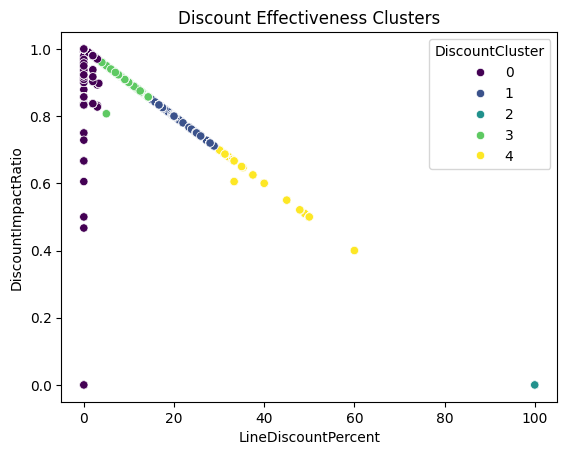

In [ ]:
# Cluster analysis
cluster_features = df[['LineDiscountPercent', 'DiscountImpactRatio']]
kmeans = KMeans(n_clusters=5)
df['DiscountCluster'] = kmeans.fit_predict(cluster_features)

# Visualize clusters
sns.scatterplot(data=df, x='LineDiscountPercent', y='DiscountImpactRatio',
                hue='DiscountCluster', palette='viridis')
plt.title("Discount Effectiveness Clusters")
plt.show()

**Profit Analysis**

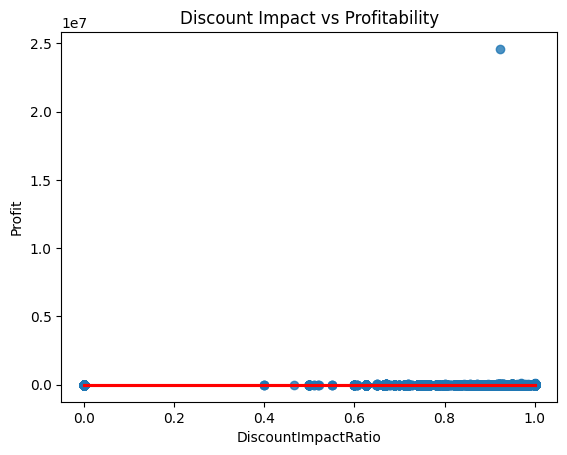

In [ ]:
# Calculate profit (example calculation - adapt to your business logic)
df['Profit'] = df['LineSalesAccountVal'] - df['ItemWiseDiscountsTotal']

# Compare discount impact vs profitability
sns.regplot(data=df, x='DiscountImpactRatio', y='Profit', line_kws={'color':'red'})
plt.title("Discount Impact vs Profitability")
plt.show()

**Model Validation & Tuning**

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestRegressor(), X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R²: {scores.mean():.4f} (±{scores.std():.4f})")

Cross-Validation R²: 0.9933 (±0.0047)


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 20, 'n_estimators': 200}


**Business Insights**

In [ ]:
optimal_discount = df.groupby('LineDiscountPercent')['Profit'].mean().idxmax()
print(f"Optimal Discount Percentage: {optimal_discount}%")

Optimal Discount Percentage: 8.36%


**Visualization & Reporting**

In [ ]:
#selecting all customers (or sales records) that belong to Cluster 2
cluster_2_customers = df[df['DiscountCluster'] == 2]

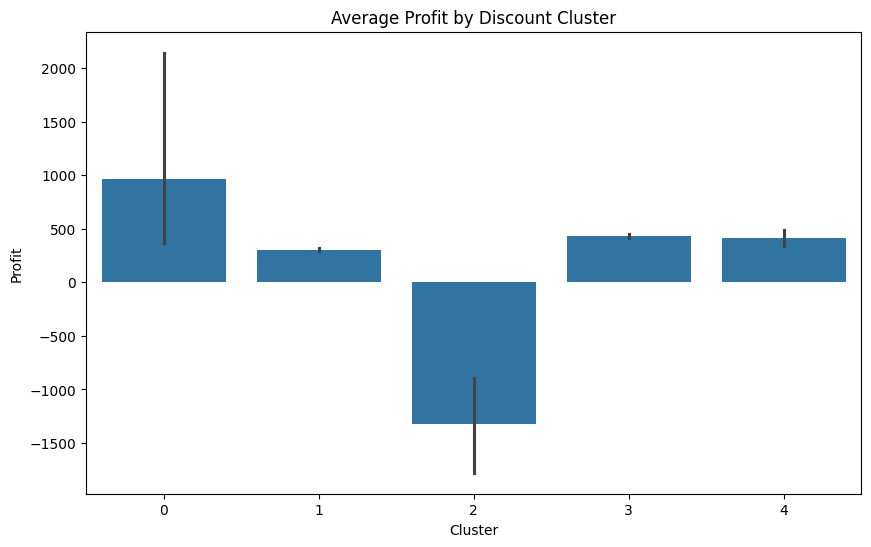

In [ ]:
#average profit per cluster
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='DiscountCluster', y='Profit', estimator=np.mean)
plt.title("Average Profit by Discount Cluster")
plt.xlabel("Cluster")
plt.ylabel("Profit")
plt.show()

In [ ]:
# Ensure necessary columns exist
if {'SalesAmount', 'Discount', 'Cost'}.issubset(df.columns):
    # Calculate Profit
    df['Profit'] = df['SalesAmount'] - (df['Cost'] + df['Discount'])


In [ ]:
df['Profit'] = df['LineSalesAccountVal'] - (df['Mrp'] + df['ItemWiseDiscountsTotal'])


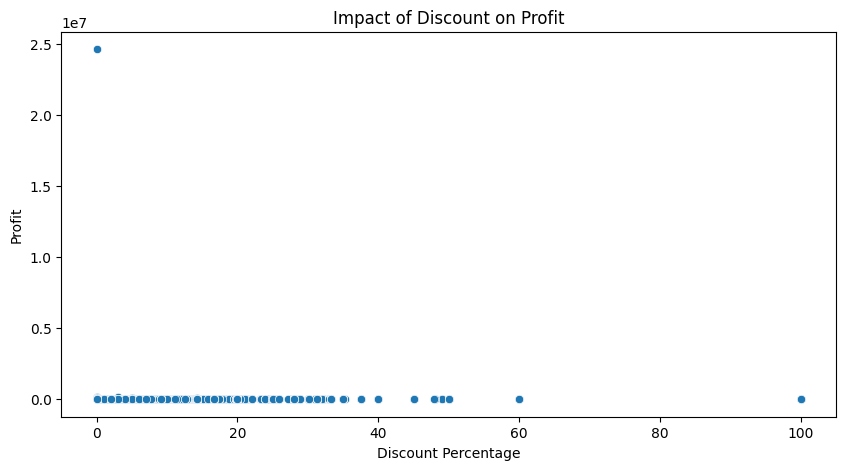

In [ ]:
# Analyze Discount vs Profit
plt.figure(figsize=(10,5))
sns.scatterplot(x=df['LineDiscountPercent'], y=df['Profit'])
plt.title("Impact of Discount on Profit")
plt.xlabel("Discount Percentage")
plt.ylabel("Profit")
plt.show()

In [ ]:
# Find Optimal Discount
max_profit = df.groupby('LineDiscountPercent')['Profit'].mean().max()

print(f"Maximum Average Profit: {max_profit}")



Maximum Average Profit: 13115.893333333333


In [ ]:

# Define a function to remove outliers using the Interquartile Range (IQR)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range

    # Define outlier boundaries (1.5 times the IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the dataset to remove outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered

# Remove outliers in the Profit column
df_cleaned = remove_outliers(df, 'Profit')

# Print before and after removing outliers
print(f"Original dataset size: {df.shape[0]}")
print(f"After removing outliers: {df_cleaned.shape[0]}")


Original dataset size: 64243
After removing outliers: 57621


In [ ]:
# Group by Discount Percentage and calculate average Profit
discount_analysis = df_cleaned.groupby('LineDiscountPercent').agg({'Profit': 'mean'}).reset_index()

# Find the optimal discount with maximum average profit
optimal_discount = discount_analysis.loc[discount_analysis['Profit'].idxmax()]

print(f"Updated Optimal Discount Rate: {optimal_discount['LineDiscountPercent']}%")
print(f"Updated Maximum Average Profit: {optimal_discount['Profit']}")


Updated Optimal Discount Rate: 7.3%
Updated Maximum Average Profit: 415.76000000000005


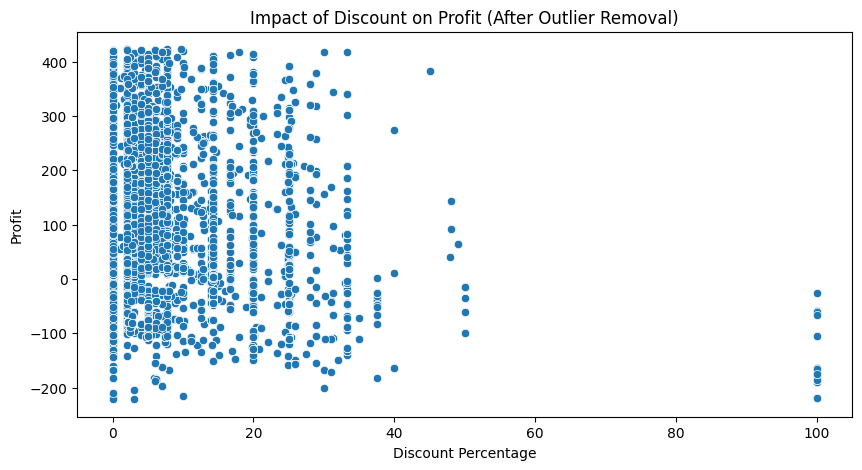

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_cleaned, x='LineDiscountPercent', y='Profit')
plt.title("Impact of Discount on Profit (After Outlier Removal)")
plt.xlabel("Discount Percentage")
plt.ylabel("Profit")
plt.show()


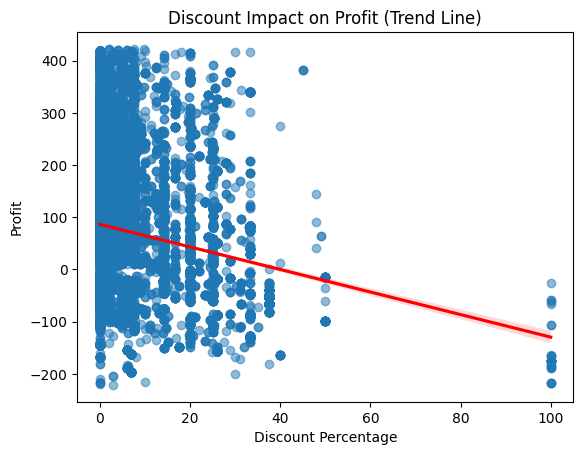

In [ ]:
#relationship between discount percentage and profit, with a trend line indicating the overall pattern.
sns.regplot(data=df_cleaned, x='LineDiscountPercent', y='Profit', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Discount Impact on Profit (Trend Line)")
plt.xlabel("Discount Percentage")
plt.ylabel("Profit")
plt.show()


In [ ]:
correlation = df_cleaned['LineDiscountPercent'].corr(df_cleaned['Profit'])
print(f"Correlation between Discount % and Profit: {correlation:.4f}")


Correlation between Discount % and Profit: -0.1500


In [ ]:
df_cleaned.groupby(pd.cut(df_cleaned['LineDiscountPercent'], bins=[0, 10, 20, 30, 50, 100]))['Profit'].mean()


<ipython-input-75-f8704b384d2e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned.groupby(pd.cut(df_cleaned['LineDiscountPercent'], bins=[0, 10, 20, 30, 50, 100]))['Profit'].mean()


,Profit
LineDiscountPercent,
"(0, 10]",89.930085
"(10, 20]",66.771542
"(20, 30]",14.658770
"(30, 50]",-26.227897
"(50, 100]",-157.853438


<Axes: xlabel='DiscountCluster', ylabel='Profit'>

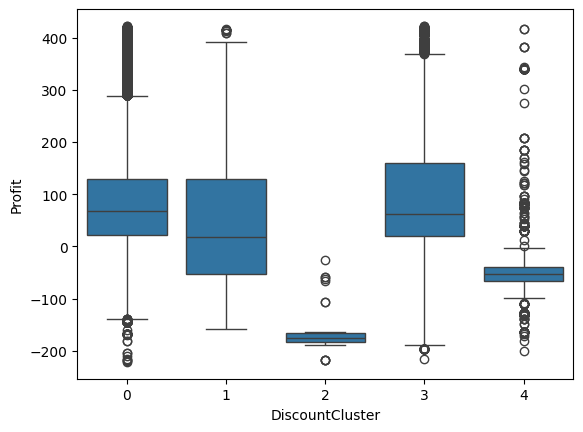

In [ ]:
sns.boxplot(data=df_cleaned, x='DiscountCluster', y='Profit')


In [ ]:
# Group by item and check sales & profit contribution
item_performance = df.groupby("Item").agg(
    total_sales=("LineSalesAccountVal", "sum"),
    total_profit=("Profit", "sum"),
    avg_discount=("LineDiscountPercent", "mean")
).reset_index()

# Identify top and bottom 10 items by profit
top_items = item_performance.sort_values(by="total_profit", ascending=False).head(10)
bottom_items = item_performance.sort_values(by="total_profit", ascending=True).head(10)

print("🔹 Top 10 Profitable Items:")
print(top_items)
print("\n🔹 Bottom 10 Items Losing Money:")
print(bottom_items)


🔹 Top 10 Profitable Items:
      Item  total_sales  total_profit  avg_discount
1117  1117  26843088.36   24601327.60      0.000000
710    710   2712783.54    2609112.13      0.253319
701    701   1401936.38    1384052.76      0.172545
711    711   1209190.16    1137441.68      0.375000
776    776    345723.46     318710.42      4.074074
769    769    304638.45     279211.12      4.280000
713    713    260585.75     246876.02      0.147368
774    774    233608.45     216458.16      3.611111
945    945    269811.69     190327.78      6.722108
767    767    200340.71     183894.34      3.900000

🔹 Bottom 10 Items Losing Money:
      Item  total_sales  total_profit  avg_discount
422    422     29727.77     -55217.79     26.743590
421    421     27157.87     -42817.87     24.560000
420    420     25948.45     -37478.13     25.971831
419    419     41400.16     -27440.38     23.295238
463    463     27641.11     -12518.06     42.859706
1082  1082     26222.77      -4538.95     26.013474
1086

 Customer Analysis

In [ ]:
# Group by customer name and analyze discount impact
customer_analysis = df.groupby("Name").agg(
    avg_discount=("LineDiscountPercent", "mean"),
    total_spent=("LineSalesAccountVal", "sum"),
    total_profit=("Profit", "sum"),
    avg_order_value=("LineSalesAccountVal", "mean")
).reset_index()

# Identify customers who receive the highest discounts
high_discount_customers = customer_analysis.sort_values(by="avg_discount", ascending=False).head(10)

print("🔹 Customers Receiving Highest Discounts:")
print(high_discount_customers)


🔹 Customers Receiving Highest Discounts:
     Name  avg_discount  total_spent  total_profit  avg_order_value
241   241     50.191731    649772.23      72950.75      6247.809904
197   197     50.000000       744.10        469.69       372.050000
137   137     50.000000       662.76        461.53       165.690000
0       0     50.000000      1488.20       1139.38       744.100000
38     38     32.404800      3993.08      -1548.35       159.723200
176   176     30.290909    119051.27      31571.46      3607.614242
591   591     29.996000       445.95       -408.57        89.190000
658   658     29.556098     33502.25      16762.76       817.128049
651   651     28.724091    114344.67      67276.08      5197.485000
558   558     28.567500       590.28       -212.68       147.570000
